In [10]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import scipy as sp
import plotly.graph_objects as go
import plotly.io as pio

from st_utils import correct_tissue_names
from st_utils import name_parser
from st_utils import log2_fold_change
from st_utils import correct_platform_panel
from constants import matching_cores, CB_COLORS_5
from constants import SAMPLES, sample_color
from constants import xenium_breast_htma_matching_cores
from constants import merscope_breast_htma_matching_cores
from constants import cosmx_multitissue_htma_matching_cores, CORRECT_PLATFORM_PANEL

# import warnings
# if not sys.warnoptions:
#     warnings.simplefilter("ignore")

wd = os.getcwd()
print (f'working directory: {wd}')


year = '2024'

samples = [x for x in SAMPLES]
if year == '2024':
    samples = [x for x in SAMPLES if '2024' in x]
elif year == '2023':
    samples = [x for x in SAMPLES if '2024' not in x]
else:
    samples = [x for x in SAMPLES]
print (samples)


def hc_linear_test(df, col1, col2):
    """
    Performs the Harvey-Collier test for linearity on two columns of a DataFrame.

    Parameters
    ----------
    df : pd.DataFrame
        The DataFrame containing the data.
    col1 : str
        The name of the independent variable column.
    col2 : str
        The name of the dependent variable column.

    Returns
    -------
    float
        The Harvey-Collier test statistic.
    float
        The p-value of the Harvey-Collier test.
    """
    # Extract the independent and dependent variables
    X = df[col1]
    y = df[col2]
    
    # Add a constant to the independent variable for the intercept
    X = sm.add_constant(X)
    
    # Fit a linear regression model
    model = sm.OLS(y, X).fit()
    
    # Perform the Harvey-Collier test
    hc_test = sm.stats.linear_harvey_collier(model)
    
    # Return the test statistic and p-value
    return hc_test.statistic, hc_test.pvalue


convert_tma_name_dict = {'HTMA':'tTMA1','TUMOR2':'tTMA2', 'NORMAL':'nTMA', 'tTMA1':'tTMA1'}

working directory: /Users/whuan/dev/ist_benchmarking
['2024_xenium_breast_htma', '2024_xenium_breast_tumor2', '2024_merscope_breast_htma', '2024_merscope_breast_tumor2', '2024_cosmx_multitissue_htma', '2024_cosmx_multitissue_tumor2']


In [11]:
by_sample = False

# Load data

In [12]:
metric = f'count'
df_m = pd.DataFrame()
for sample in samples:
    print (f'sample: {sample}')
    df_t = pd.read_csv(f'{wd}/data/gene_level_csv/gene_level_csv_{sample}.csv')
    df_t = correct_tissue_names(sample, df_t)
    # Reindex normal tissue cores 
    df_t['core'] += (300 if 'tumor2' in sample else 0) + (200 if 'normal' in sample else 0)
    # Consolidate tissue type
    # df_t = df_t.replace({'LN':'Lymph node','MARKER':'Marker'}) if 'htma' in sample else df_t
    df_t['sample'] = sample
    df_m = pd.concat([df_m,df_t])
    
df_m = df_m.loc[df_m['core'].isin(matching_cores)]
df_m['platform'] = df_m['sample'].apply(lambda x: name_parser(x)['platform'].upper())
df_m['panel'] = df_m['sample'].apply(lambda x: name_parser(x)['panel'])
df_m['tma'] = df_m['sample'].apply(lambda x: name_parser(x)['tma'].upper())

df_plot = df_m.copy()
df_plot = df_plot.drop(['sample'], axis=1)
df_plot = df_plot.groupby(['platform','panel','gene']).agg({metric: 'sum'}).reset_index()
df_plot['platform_panel'] = df_plot.apply(lambda row: f"{row['platform']},{row['panel']}", axis=1)
df_plot = df_plot.pivot(index = 'gene', columns = 'platform_panel', values = 'count').reset_index()

if by_sample:
    df_plot = df_m.copy()
    df_plot = df_plot.groupby(['sample','gene']).agg({metric: 'sum'}).reset_index()
    df_plot = df_plot.pivot(index = 'gene', columns = 'sample', values = 'count').reset_index()

sample: 2024_xenium_breast_htma
sample: 2024_xenium_breast_tumor2
sample: 2024_merscope_breast_htma
sample: 2024_merscope_breast_tumor2
sample: 2024_cosmx_multitissue_htma
sample: 2024_cosmx_multitissue_tumor2


In [13]:


def gene_by_gene_plot(df_plot, platform_panel_1, platform_panel_2, tmas, year, color_index, linear_p_value_threshold=0.05, fontsize=20, lw=3, marker_size =40):
    df_pair = df_plot[['gene', platform_panel_1, platform_panel_2]]
    df_pair = df_pair.reset_index(drop=True).dropna()

    Log_transform_method = 'non'
    df_pair['fold'] = df_pair.apply(lambda row: row[platform_panel_1] / row[platform_panel_2], axis=1)
    # df_pair = log_transform(df_pair, method=Log_transform_method, exclude_cols=['fold'])

    hc_linear_statistic, hc_linear_pvalue = hc_linear_test(df_pair, platform_panel_1, platform_panel_2)
    linear = hc_linear_pvalue >= linear_p_value_threshold
    print('Linear:', linear)

    degree = 1 if linear else 1
    x = df_pair[platform_panel_1]
    y = df_pair[platform_panel_2]
    coefficients = np.polyfit(x, y, degree)
    polynomial = np.poly1d(coefficients)
    y_fit = polynomial(x)
    residuals = y - y_fit  # Calculate residuals

    # Scatter plot with polynomial fit
    plt.figure(figsize=(6, 6))
    sns.regplot(
        data=df_pair,
        x=platform_panel_1,
        y=platform_panel_2,
        color=list(CB_COLORS_5.values())[color_index],
        fit_reg=False,
        robust=False,
        order=degree,
        scatter_kws={'facecolors': 'none', 'lw': lw, 's': marker_size},
        ci=None,
    )
    x_poly = np.linspace(min(x), max(x), 100)
    y_poly = polynomial(x_poly)
    # plt.plot(x_poly, y_poly, label='', color='red')

    # Add 1:1 dashed line based on tmas value

    if Log_transform_method == 'log2':
        if tmas == ['HTMA']:
            lims = [5, 20]
        elif tmas == ['TUMOR2']:
            lims = [3, 20]
        elif tmas == ['tTMA1']:
            lims = [4, 25]
        else:
            lims = [3, 20]

    elif Log_transform_method == 'log10':
        if tmas == ['HTMA']:
            lims = [1, 6.5]
        elif tmas == ['TUMOR2']:
            lims = [1, 6.5]
        elif tmas == ['tTMA1']:
            lims = [0, 6.5]
        else:
            lims = [1, 6.5]

    elif Log_transform_method == 'non':
        if tmas == ['HTMA']:
            lims = [10**1, 10**6.5]
        elif tmas == ['TUMOR2']:
            lims = [10**1, 10**6.5]
        elif tmas == ['tTMA1']:
            lims = [10**0, 10**6.5]
        else:
            lims = [10**1, 10**6.5]
    else:
        if tmas == ['HTMA']:
            lims = [5, 20]
        elif tmas == ['TUMOR2']:
            lims = [3, 20]
        elif tmas == ['tTMA1']:
            lims = [4, 25]
        else:
            lims = [3, 20]           


    plt.plot(lims, lims, 'k-.', alpha=0.75)

    # Stats and annotation
    r, p = sp.stats.spearmanr(x, y)
    p_text = '< 0.0001' if p < 0.0001 else f"= {round(p, 7)}"
    annotation_text = f"Spearman R = {round(r,2)}\np value {p_text}\nMedian fold = {df_pair['fold'].median():.2f}"
    if year == '2024':
        plt.text(10**3, 10**2, annotation_text, fontsize=fontsize, verticalalignment='top')
    elif year == '2023':
        plt.text(10**1, 10**6.5, annotation_text, fontsize=fontsize, verticalalignment='top')
    else:
        plt.text(10**0, 10**6.5, annotation_text, fontsize=fontsize, verticalalignment='top')
    # Axes and labels

    if tmas == ['tTMA1']:
        plt.xlabel(f"Gene expression of\n{platform_panel_1}", fontsize=fontsize)
        plt.ylabel(f"Gene expression of\n{platform_panel_2}", fontsize=fontsize)
    else:
        plt.xlabel(f"Gene expression of\n{platform_panel_1} from {convert_tma_name_dict[tmas[0]]}({year[-2:]})", fontsize=fontsize)
        plt.ylabel(f"Gene expression of\n{platform_panel_2} from {convert_tma_name_dict[tmas[0]]}({year[-2:]})", fontsize=fontsize)


    plt.xscale('log')
    plt.yscale('log')

    # plt.xlim(lims[0], lims[1])
    # plt.ylim(lims[0], lims[1])
    plt.legend(loc='upper center', bbox_to_anchor=(0.4, 0.1), frameon=False, fontsize=fontsize)

    # Save and show the plot
    plt.savefig(f"{wd}/figures/Fig_2_Technical_Performance/Main_Fig_2_ABC_{year}_{platform_panel_1}_vs_{platform_panel_2}_from_{'_and_'.join(tmas)}.png", bbox_inches='tight', transparent=True)
    plt.savefig(f"{wd}/figures/Fig_2_Technical_Performance/Main_Fig_2_ABC_{year}_{platform_panel_1}_vs_{platform_panel_2}_from_{'_and_'.join(tmas)}.eps", bbox_inches='tight', transparent=True)
    plt.show()

    # Residual plot

    # Log10 transform data and handel negative values.
    x_transformed = np.log10(x + 1)
    residuals_transformed = np.log10(np.abs(residuals) + 1)

    plt.figure(figsize=(6, 6))
    sns.residplot(x=x_transformed, y=residuals_transformed, lowess=False, color=list(CB_COLORS_5.values())[color_index], scatter_kws={'facecolors': 'none', 'lw': lw, 's': marker_size})
    plt.axhline(0, color='red', linestyle='--', lw=2)

    if tmas == ['tTMA1']:
        plt.xlabel(f"Gene exp. residual (log10 transformed) of\n{platform_panel_1} vs. (23)", fontsize=fontsize)
    else:
        plt.xlabel(f"Gene exp. residual (log10 transformed) of\n{platform_panel_1} vs. {platform_panel_2}\nfrom {convert_tma_name_dict[tmas[0]]}({year[-2:]})", fontsize=fontsize)


    plt.ylabel('Residuals', fontsize=fontsize)

    plt.xlim(1,6.5)
    plt.ylim(-7, 7)


    plt.title('')
    plt.tight_layout()

    plt.savefig(f"{wd}/figures/Fig_2_Technical_Performance/Residual_{year}_{platform_panel_1}_vs_{platform_panel_2}_from_{'_and_'.join(tmas)}.png", bbox_inches='tight', transparent=True)
    plt.savefig(f"{wd}/figures/Fig_2_Technical_Performance/Residual_{year}_{platform_panel_1}_vs_{platform_panel_2}_from_{'_and_'.join(tmas)}.eps", bbox_inches='tight', transparent=True)   
    plt.show()




# Plot gene-by-gene plot between Platform-panels by TMA

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Xenium,breast CosMx,1k ['HTMA']
Linear: True


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


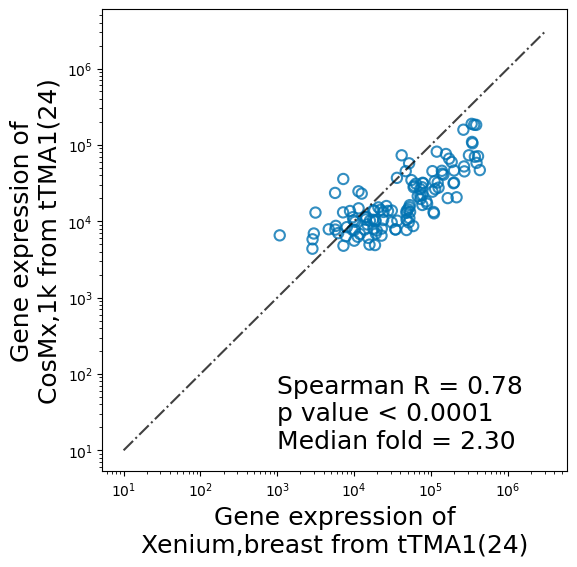

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


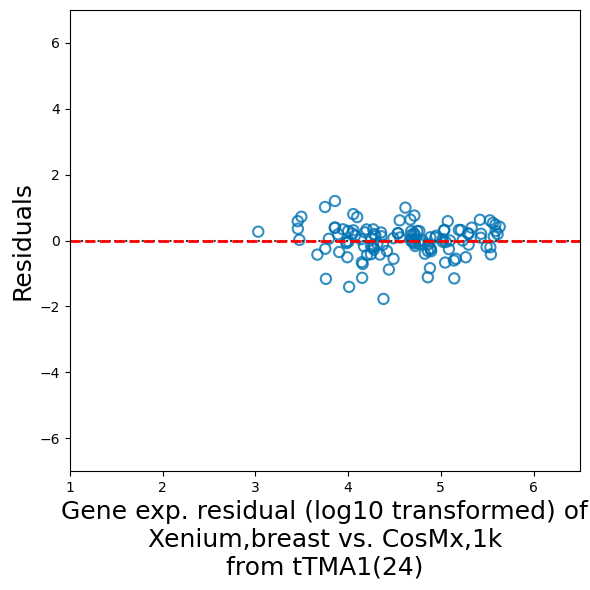

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MERSCOPE,breast CosMx,1k ['HTMA']
Linear: False


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


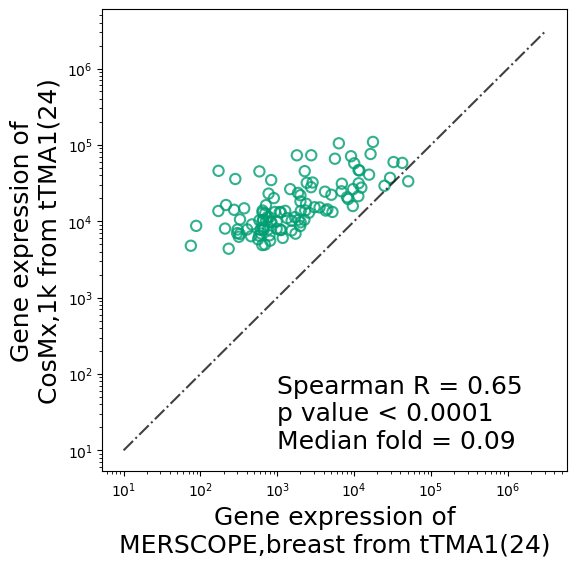

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


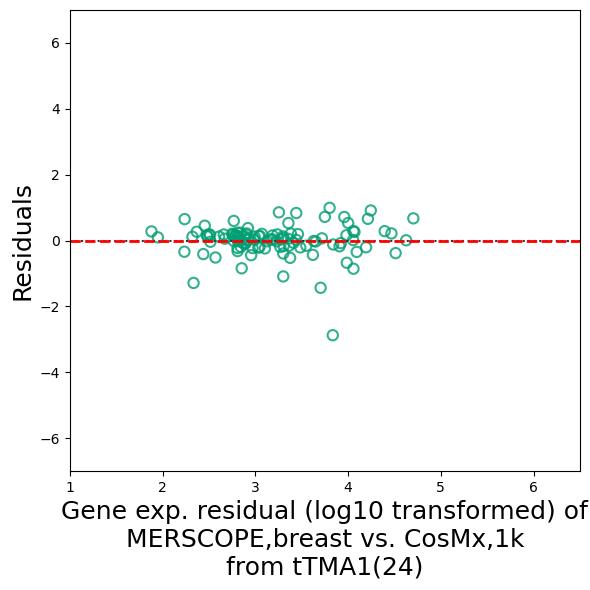

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MERSCOPE,breast Xenium,breast ['HTMA']
Linear: True


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


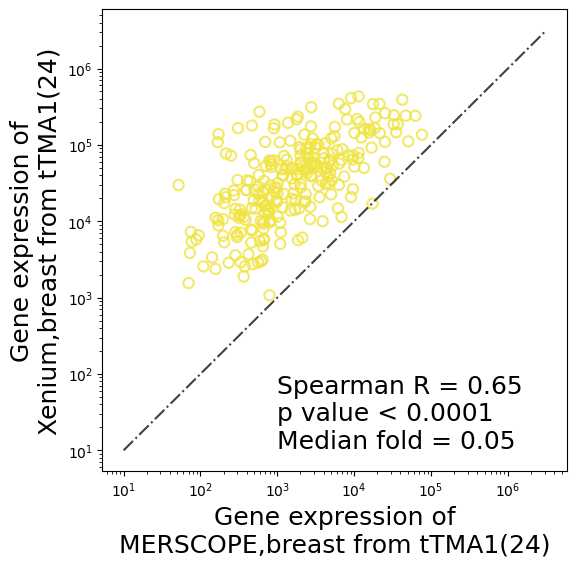

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


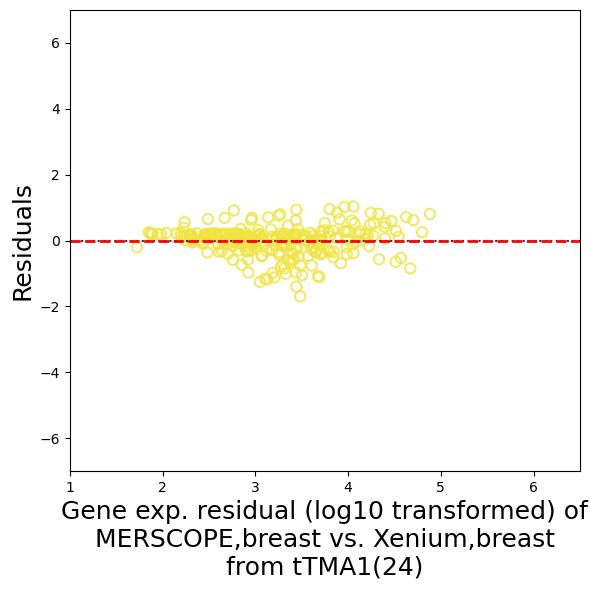

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Xenium,breast CosMx,1k ['TUMOR2']
Linear: True


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


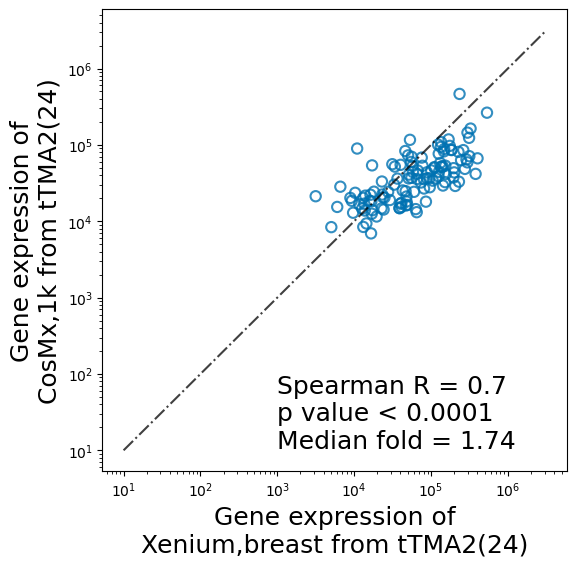

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


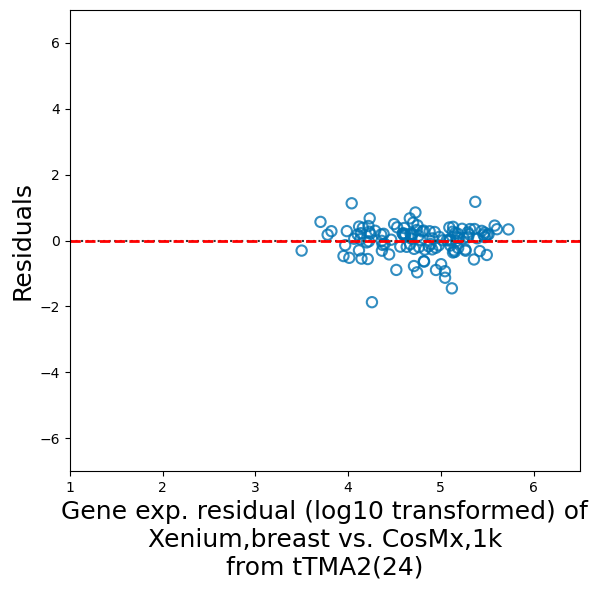

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MERSCOPE,breast CosMx,1k ['TUMOR2']
Linear: True


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


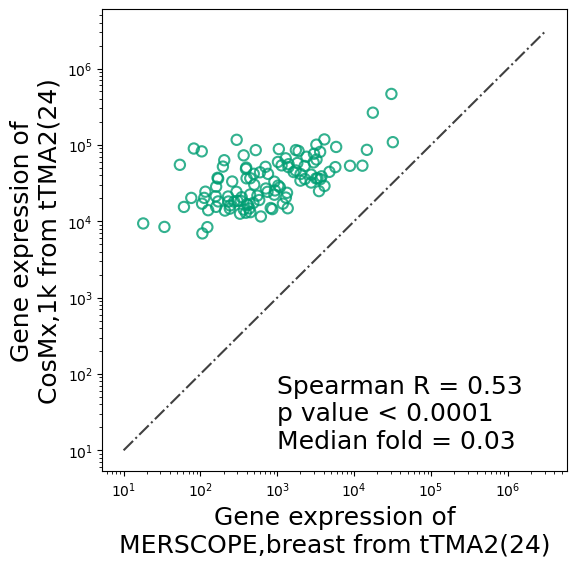

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


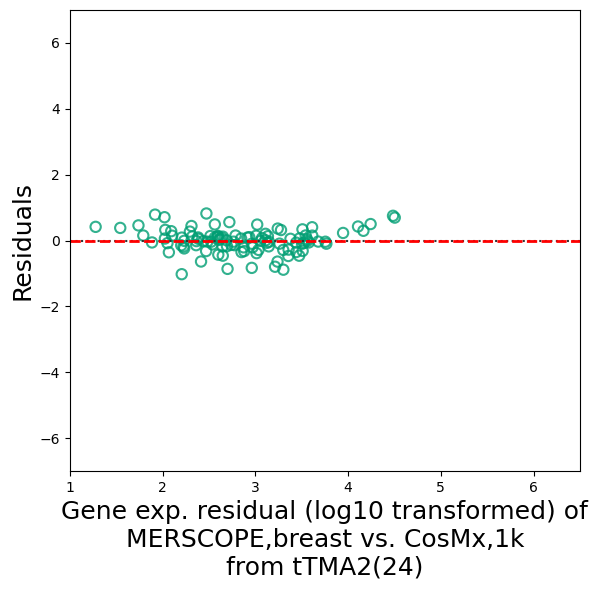

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MERSCOPE,breast Xenium,breast ['TUMOR2']
Linear: True


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


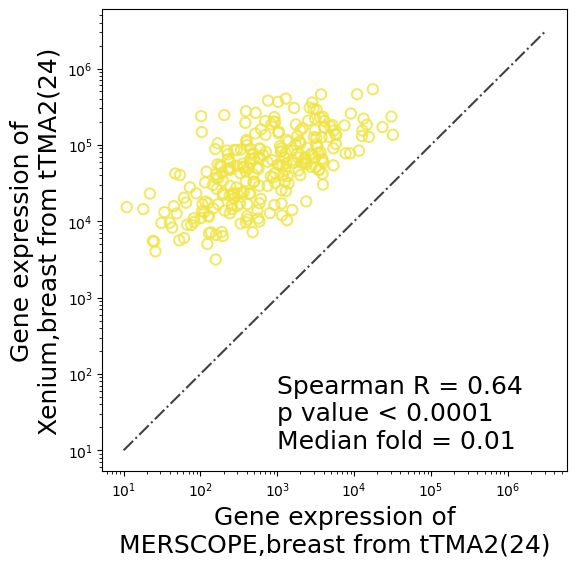

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


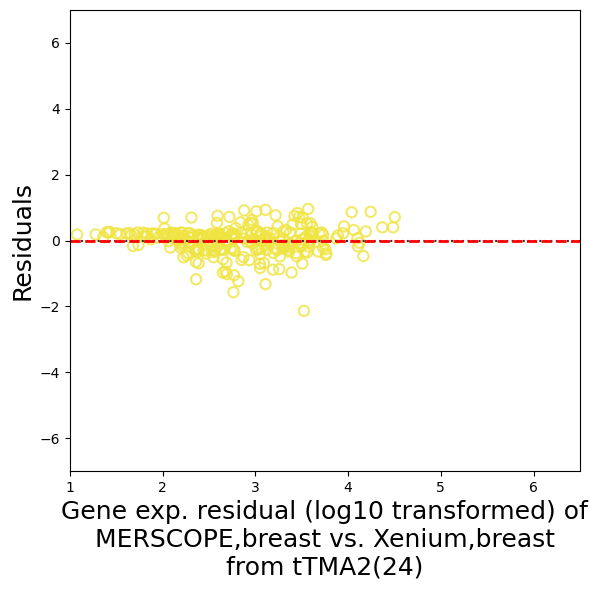

In [14]:
if not os.path.exists(f'{wd}/figures/Fig_2_Technical_Performance'):
    os.makedirs(f'{wd}/figures/Fig_2_Technical_Performance')

linear_p_value_threshold = 0.05
fontsize=18

if year =='2023':

    for tmas in [['HTMA'], ['NORMAL']]:
        df_plot = df_m.loc[df_m['tma'].isin(tmas)]
        df_plot = df_plot.drop(['sample'], axis=1)
        df_plot = df_plot.groupby(['platform','panel','gene']).agg({metric: 'sum'}).reset_index()
        df_plot['platform_panel'] = df_plot.apply(lambda row: f"{row['platform']}_{row['panel']}", axis=1)
        df_plot = df_plot.pivot(index = 'gene', columns = 'platform_panel', values = 'count').reset_index()
        df_plot.columns = ['gene',
                    'CosMx,1k',
                    'MERSCOPE,breast', 
                    'MERSCOPE,lung',
                    'Xenium,breast',
                    'Xenium,lung',
                    'Xenium,multi-tissue']

        for count, platform_panel_pair in enumerate([('Xenium,breast','CosMx,1k'),
                                    ('Xenium,lung','CosMx,1k'),
                                    ('MERSCOPE,breast','CosMx,1k'),
                                    ('MERSCOPE,lung','CosMx,1k'),
                                    ('Xenium,breast','MERSCOPE,breast'),
                                    ('Xenium,lung','MERSCOPE,lung'),
                                    ('Xenium,multi-tissue','CosMx,1k')
                                    ]):
            color_index = int(np.floor(count/2+1))

            platform_panel_1 = platform_panel_pair[0]
            platform_panel_2 = platform_panel_pair[1]

            print(platform_panel_1, platform_panel_2, tmas)

            gene_by_gene_plot(
                df_plot,
                platform_panel_1,
                platform_panel_2,
                tmas,
                year,
                color_index,
                linear_p_value_threshold=linear_p_value_threshold,
                fontsize=fontsize,
                lw=1.5,
                marker_size=55,

            )

elif year =='2024':

    for tmas in [['HTMA'], ['TUMOR2']]:
        df_plot = df_m.loc[df_m['tma'].isin(tmas)]
        df_plot = df_plot.drop(['sample'], axis=1)
        df_plot = df_plot.groupby(['platform','panel','gene']).agg({metric: 'sum'}).reset_index()
        df_plot['platform_panel'] = df_plot.apply(lambda row: f"{row['platform']}_{row['panel']}", axis=1)
        df_plot = df_plot.pivot(index = 'gene', columns = 'platform_panel', values = 'count').reset_index()
        df_plot.columns = ['gene',
                    'CosMx,1k',
                    'MERSCOPE,breast', 
                    'Xenium,breast']

        for count, platform_panel_pair in enumerate([
            ('Xenium,breast','CosMx,1k'),
            ('MERSCOPE,breast','CosMx,1k'),
            ('MERSCOPE,breast','Xenium,breast'),
            ]):

            color_index = count + 1
            
            platform_panel_1 = platform_panel_pair[0]
            platform_panel_2 = platform_panel_pair[1]

            print(platform_panel_1, platform_panel_2, tmas)
            
            gene_by_gene_plot(
                df_plot,
                platform_panel_1,
                platform_panel_2,
                tmas,
                year,
                color_index,
                linear_p_value_threshold=linear_p_value_threshold,
                fontsize=fontsize,
                lw=1.5,
                marker_size=55,
            )

# Core to core reproducibility (2023 method, depreciated)

105 106
sample: xenium_breast_htma


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


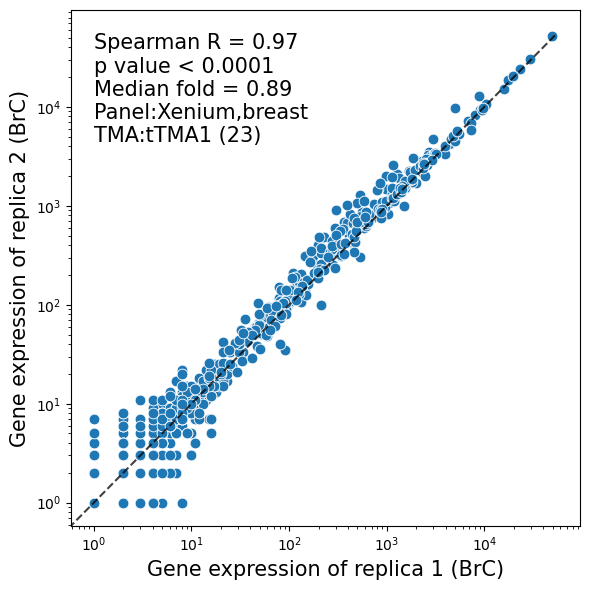

sample: xenium_panhuman_htma


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


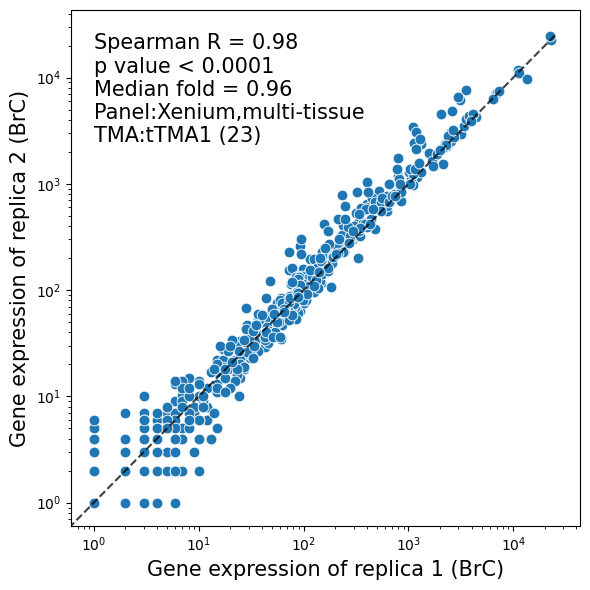

sample: xenium_lung_htma


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


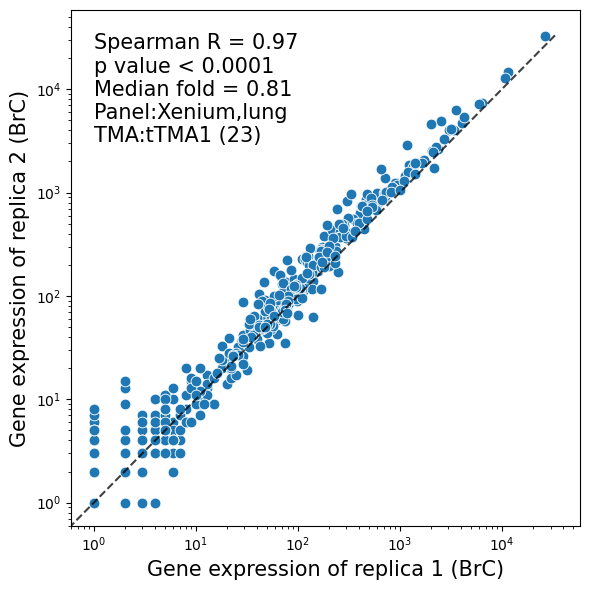

sample: merscope_breast_htma


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


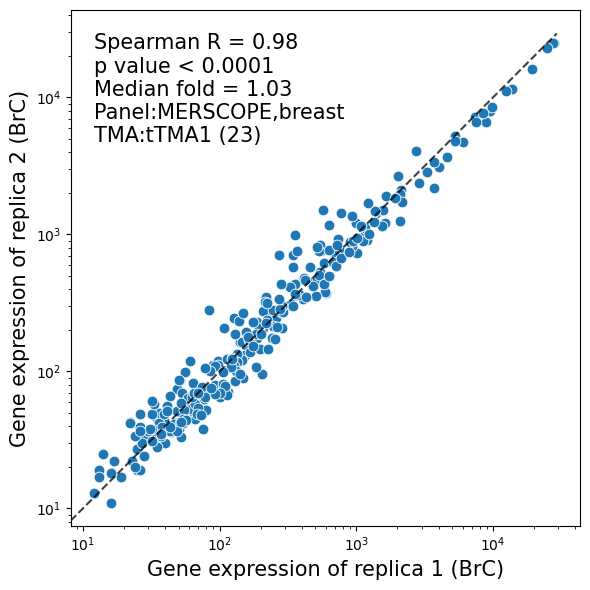

sample: merscope_lung_htma


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


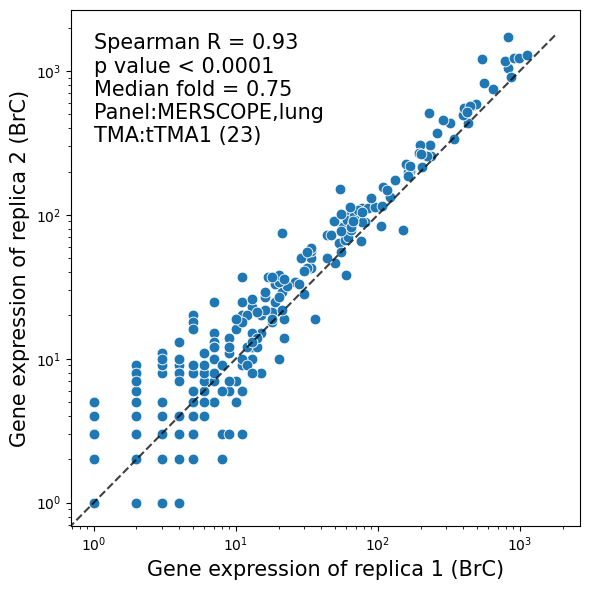

sample: cosmx_multitissue_htma


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


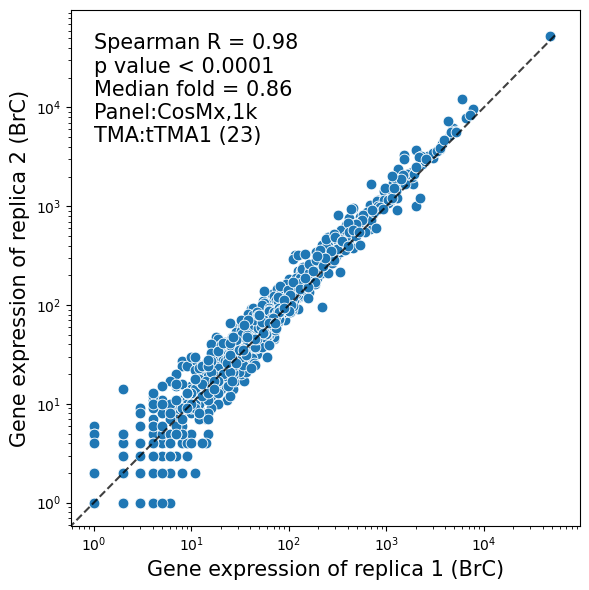

In [17]:
if not os.path.exists(f'{wd}/figures/Fig_1'):
    os.makedirs(f'{wd}/figures/Fig_1')
Log_transform_method = 'log10'
rs = []
sams = []
core_ps = []
fontsize = 15

for core_pair in [[105, 106]]:
    core_1 = core_pair[0]
    core_2 = core_pair[1]
    print (core_1, core_2)
    
    metric = f'count'
    df_m = pd.DataFrame()
    # for sample in ['xenium_lung_htma','merscope_breast_htma','cosmx_multitissue_htma']:
    for sample in SAMPLES[::2]:
        if '2024'  not in sample:

            print (f'sample: {sample}')
            df_t = pd.read_csv(f'{wd}/data/gene_level_csv/gene_level_csv_{sample}.csv')
            df_t = correct_tissue_names(sample, df_t)
            # Reindex normal tissue cores 
            df_t.core = df_t.core + 200 if 'normal' in sample else df_t.core
            platform_panel = CORRECT_PLATFORM_PANEL['_'.join(sample.split('_')[:2])]
            df_core_1 = df_t.loc[df_t['core']==core_1][['gene','tissue_type','count']]
            df_core_1 = df_core_1.rename(columns={'count':f'Core_{core_1}'})
            df_core_2 = df_t.loc[df_t['core']==core_2][['gene','count']]
            df_core_2 = df_core_2.rename(columns={'count':f'Core_{core_2}'})
            df_core_pair = pd.merge(df_core_1, df_core_2, on='gene', how='inner')

            df_core_pair['fold'] = df_core_pair.apply(lambda row: round(row[f'Core_{core_1}'] /row[f'Core_{core_2}'], 3), axis=1)
            # df_core_pair = log_transform(df_core_pair, method=Log_transform_method, exclude_cols=['fold', 'core'])

            # Scatter plot
            plt.figure(figsize=(6, 6))
            sns.scatterplot(data=df_core_pair, x=f'Core_{core_1}', y=f'Core_{core_2}', s=60)

            r, p = sp.stats.spearmanr(df_core_pair[f'Core_{core_1}'], df_core_pair[f'Core_{core_2}'])
            p = '< 0.0001' if p < 0.0001 else round(p, 7)


            lims1 = [np.min([plt.xlim(), plt.ylim()]), np.max([plt.xlim(), plt.ylim()])]
            lims2 = [np.max([plt.xlim(), plt.ylim()]), np.max([plt.xlim(), plt.ylim()])]
            plt.plot(lims1, lims1, 'k--', alpha=0.75)
            plt.xscale('log')
            plt.yscale('log')
            plt.text(df_core_pair[f'Core_{core_1}'].min(), lims2[1], f"Spearman R = {round(r,2)}\np value {p}\nMedian fold = {df_core_pair['fold'].median():.2f}\nPanel:{platform_panel}\nTMA:tTMA1 (23)", fontsize=fontsize, verticalalignment='top')
            plt.xlabel(f'Gene expression of replica 1 (BrC)', fontsize=fontsize)
            plt.ylabel(f'Gene expression of replica 2 (BrC)', fontsize=fontsize)
            plt.tight_layout()
            plt.savefig(f'{wd}/figures/Fig_1/supp_1_Core_{core_1}_vs_Core_{core_2}_reproducibility_{platform_panel}.png', bbox_inches='tight', transparent=True )
            plt.savefig(f'{wd}/figures/Fig_1/supp_1_Core_{core_1}_vs_Core_{core_2}_reproducibility_{platform_panel}.eps', bbox_inches='tight', transparent=True)
            plt.show()

        rs.append(round(r,3))
        core_ps.append(f'Core {str(core_1).zfill(3)} vs. {str(core_2).zfill(3)}')
        sams.append(sample.upper())


88 89
95 96
105 106
109 110
111 112
115 116
131 132
151 152
156 157
158 159
165 166
168 169


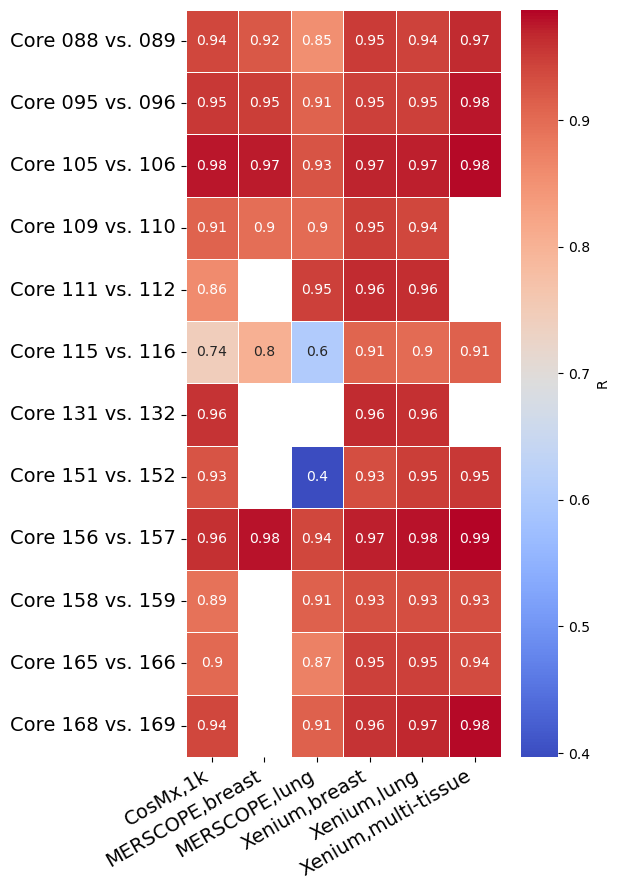

In [18]:
rs = []
sams = []
core_ps = []

for core_pair in [[88, 89],
                [95, 96],
                [105, 106],
                [109, 110],
                [111, 112],
                [115, 116],
                [131, 132],
                [151, 152],
                [156, 157],
                [158, 159],
                [165, 166],
                [168, 169]]:
    core_1 = core_pair[0]
    core_2 = core_pair[1]
    print (core_1, core_2)


    metric = f'count'
    df_m = pd.DataFrame()
    # for sample in ['xenium_lung_htma','merscope_breast_htma','cosmx_multitissue_htma']:
    for sample in SAMPLES[::2]:

        try:
            # print (f'sample: {sample}')
            df_t = pd.read_csv(f'{wd}/data/gene_level_csv/gene_level_csv_{sample}.csv')
            df_t = correct_tissue_names(sample, df_t)
            # Reindex normal tissue cores 
            df_t['core'] += (300 if 'tumor2' in sample else 0) + (200 if 'normal' in sample else 0)
            # Consolidate tissue type

            platform_panel = CORRECT_PLATFORM_PANEL['_'.join(sample.split('_')[:2])]

            df_core_1 = df_t.loc[df_t['core']==core_1][['gene','tissue_type','count']]
            df_core_1 = df_core_1.rename(columns={'count':f'Core_{core_1}'})
            df_core_2 = df_t.loc[df_t['core']==core_2][['gene','count']]
            df_core_2 = df_core_2.rename(columns={'count':f'Core_{core_2}'})
            df_core_pair = pd.merge(df_core_1, df_core_2, on='gene', how='inner')
            df_core_pair['fold'] = df_core_pair.apply(lambda row: round(row[f'Core_{core_1}'] /row[f'Core_{core_2}']), axis=1)
            r, p = sp.stats.spearmanr(df_core_pair[f'Core_{core_1}'], df_core_pair[f'Core_{core_2}'])
            p = '< 0.0001' if p < 0.0001 else round(p, 7)
            rs.append(round(r,3))
            core_ps.append(f'Core {str(core_1).zfill(3)} vs. {str(core_2).zfill(3)}')
            sams.append(sample.upper())
        except:
            continue


df = pd.DataFrame({'Sample':sams, 'Core Pair':core_ps, 'Correlation':rs})
df['Platform_Panel'] = df['Sample'].apply(lambda x: f"{x.split('_')[0]}_{x.split('_')[1]}")
df = correct_platform_panel(df, 'Platform_Panel')
df_plot = df.copy()
df_plot = df_plot.sort_values(by=['Core Pair'])
df_plot = df_plot.pivot(index='Platform_Panel', columns='Core Pair', values='Correlation')


# Create the heatmap with annotations
plt.figure(figsize=(6, 9))
g = sns.heatmap(df_plot.T, annot=True, cmap='coolwarm', linewidths=0.5,cbar_kws={'label': 'R'})
cbar = g.collections[0].colorbar
cbar.ax.set_position([0.6, 0.1, 0.1, 0.77]) #
# cbar.ax.set_ylabel(f"{' '.join(metric.split('_')).capitalize()} per cell across tissue types by platform x panel", rotation=270, labelpad=20, fontsize=16)
plt.xlabel('')
plt.ylabel('')

fontsize=14
xlabels = g.get_xticklabels()
g.set_xticklabels(xlabels, fontsize=fontsize, rotation=30, ha="right")

ylabels = g.get_yticklabels()
g.set_yticklabels(ylabels, fontsize=fontsize)

plt.tight_layout()
plt.savefig(f'{wd}/figures/Fig_1/supp_1_heatmap_of_core_reproducibility.png', dpi=250, transparent=True)
plt.savefig(f'{wd}/figures/Fig_1/supp_1_heatmap_of_core_reproducibility.eps', dpi=250, transparent=True)
plt.show()

# Real sample to sample reproducibility

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


xenium_breast_tTMA1(24) xenium_breast_tTMA1(23)
Linear: True


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


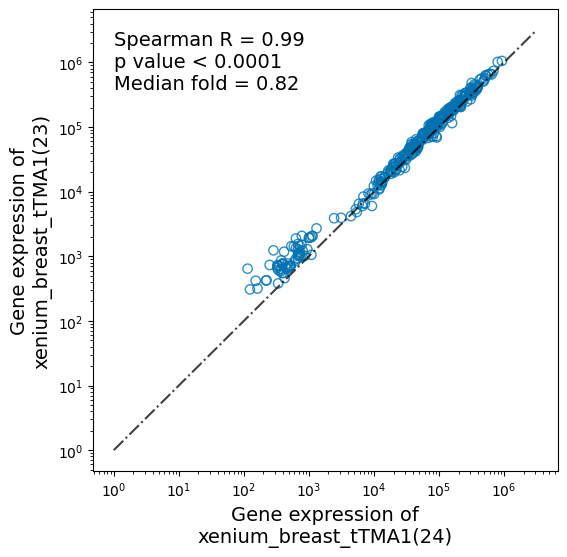

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


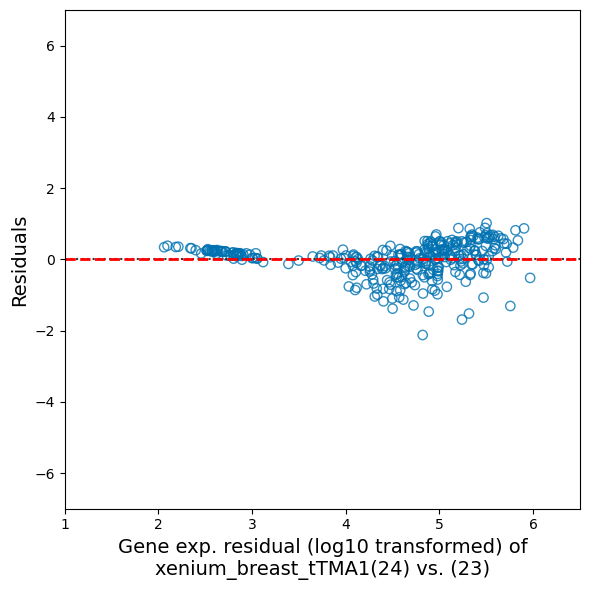

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


cosmx_multitissue_tTMA1(24) cosmx_multitissue_tTMA1(23)
Linear: True


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


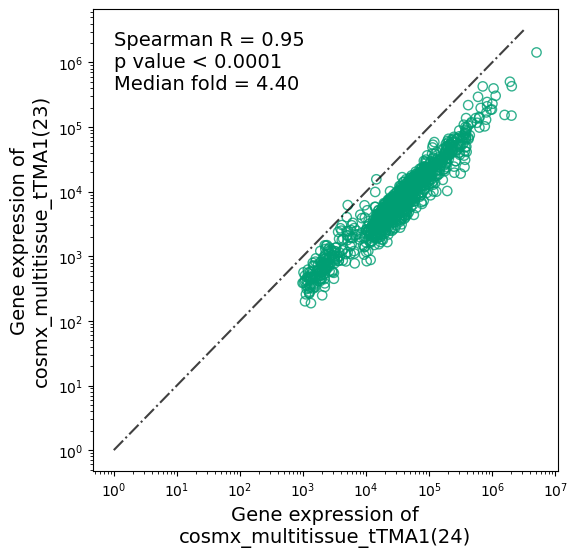

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


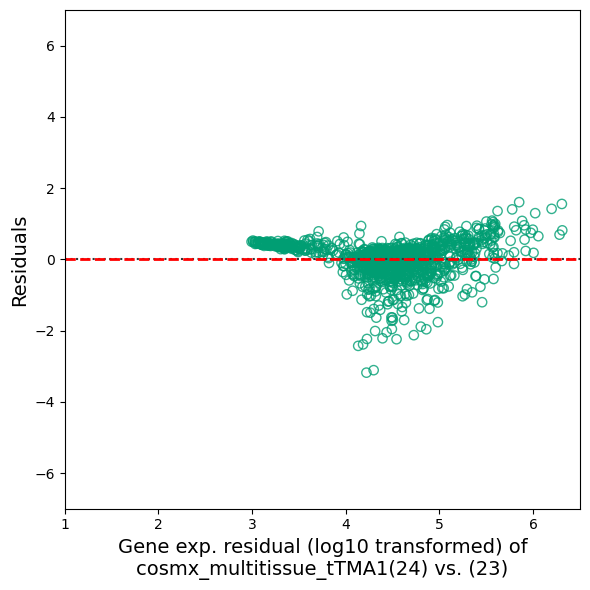

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


merscope_breast_tTMA1(24) merscope_breast_tTMA1(23)
Linear: True


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


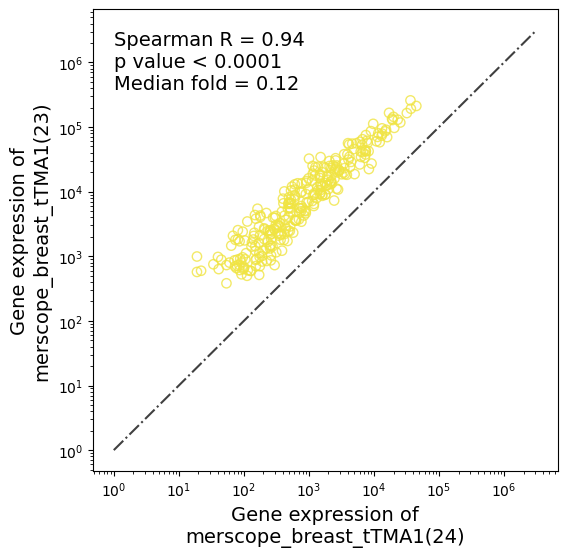

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


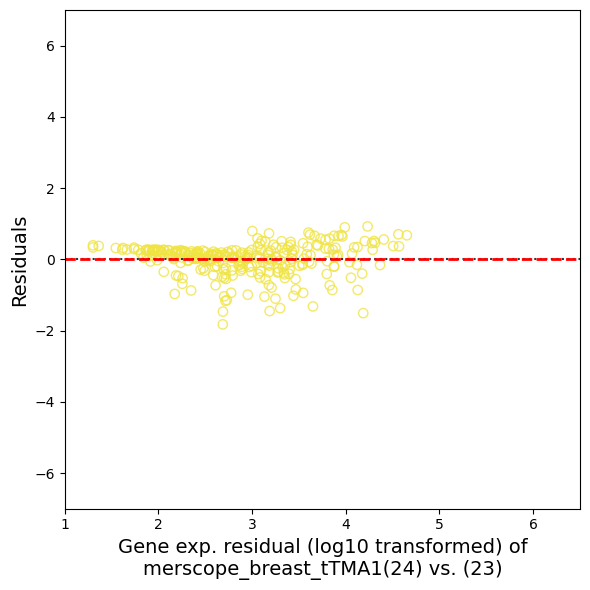

In [19]:
if not os.path.exists(f'{wd}/figures/Fig_2_Technical_Performance'):
    os.makedirs(f'{wd}/figures/Fig_2_Technical_Performance')

metric = f'count'
df_m = pd.DataFrame()
for sample in SAMPLES:
    if 'htma' in sample:
        # print (f'sample: {sample}')
        df_t = pd.read_csv(f'{wd}/data/gene_level_csv/gene_level_csv_{sample}.csv')
        df_t = correct_tissue_names(sample, df_t)
        df_t['core'] += (300 if 'tumor2' in sample else 0) + (200 if 'normal' in sample else 0)
        df_t['sample'] = sample

        matching_cores = xenium_breast_htma_matching_cores if 'xenium' in sample else merscope_breast_htma_matching_cores if 'merscope' in sample else cosmx_multitissue_htma_matching_cores if 'cosmx' in sample else None
        df_t = df_t.loc[df_t['core'].isin(matching_cores)]
        df_m = pd.concat([df_m,df_t])

tma_name = 'tTMA1'


def trim_name(sample_name, tma_name):
    if '2024' in sample_name:
        return f"{sample_name.split('2024_')[1]}(24)"
    else:
        return f"{sample_name.replace(tma_name,f'{tma_name}(23)')}"

df_m['platform'] = df_m['sample'].apply(lambda x: name_parser(x)['platform'].upper())
df_m['panel'] = df_m['sample'].apply(lambda x: name_parser(x)['panel'])
df_m['sample'] = df_m['sample'].apply(lambda x: x.replace('htma',tma_name))
df_m['sample'] = df_m['sample'].apply(lambda x: trim_name(x, tma_name))


df_plot = df_m.copy()
df_plot = df_plot.groupby(['sample','gene']).agg({metric: 'sum'}).reset_index()
df_plot = df_plot.pivot(index = 'gene', columns = 'sample', values = 'count').reset_index()

for count, sample_pair in enumerate([
    (f'xenium_breast_{tma_name}(24)',f'xenium_breast_{tma_name}(23)'),
    (f'cosmx_multitissue_{tma_name}(24)',f'cosmx_multitissue_{tma_name}(23)'),
    (f'merscope_breast_{tma_name}(24)',f'merscope_breast_{tma_name}(23)')
    ]):

    color_index = count + 1

    sample_1 = sample_pair[0]
    sample_2 = sample_pair[1]

    print(sample_1, sample_2)

    gene_by_gene_plot(
        df_plot,
        sample_1,
        sample_2,
        [tma_name],
        '2023_&_2024',
        color_index,
        linear_p_value_threshold=linear_p_value_threshold,
        fontsize=fontsize,
        lw=1,
        marker_size=45,
    )



## Real core to core reproducibility

['2024_xenium_breast_htma', 'xenium_breast_htma']
Liner: True


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


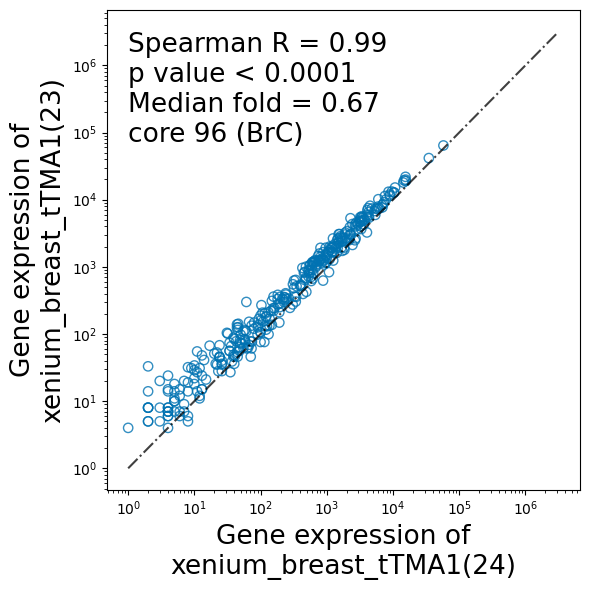

['2024_cosmx_multitissue_htma', 'cosmx_multitissue_htma']
Liner: True


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


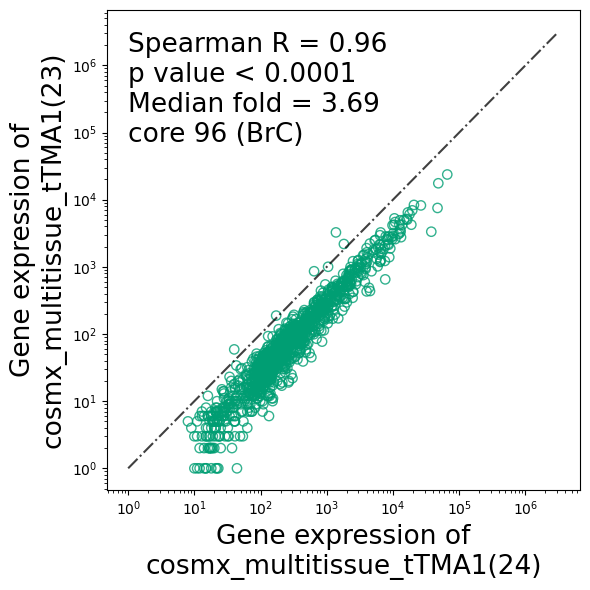

['2024_merscope_breast_htma', 'merscope_breast_htma']
Liner: True


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


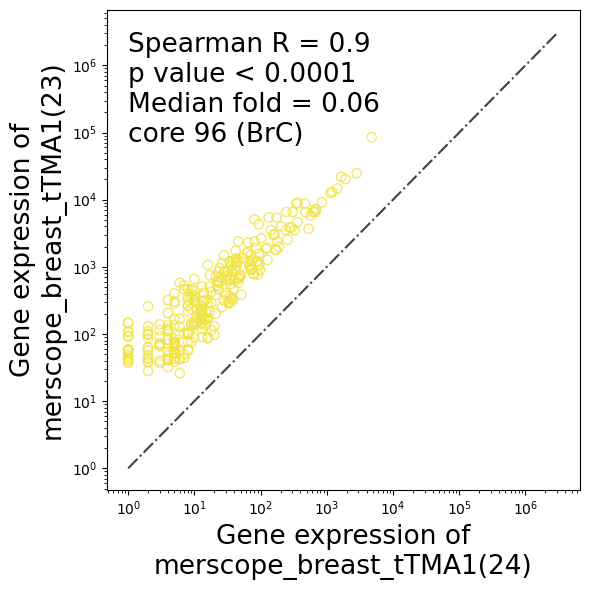

In [20]:
if not os.path.exists(f'{wd}/figures/Fig_1'):
    os.makedirs(f'{wd}/figures/Fig_1')

fontsize = 19
Log_transform_method = 'non'

rs = []
cores = []
core_ps = []
median_folds = []
log2fcs = []

for count, sample_pair in enumerate([
    ['2024_xenium_breast_htma','xenium_breast_htma'],
    ['2024_cosmx_multitissue_htma','cosmx_multitissue_htma'],
    ['2024_merscope_breast_htma','merscope_breast_htma']
    ]):
    
    color_index = count + 1
    print (sample_pair)
    metric = f'count'
    df_m = {}

    sps = []
    for sample in sample_pair:

        df_t = pd.read_csv(f'{wd}/data/gene_level_csv/gene_level_csv_{sample}.csv')
        df_t = correct_tissue_names(sample, df_t)
        df_t['core'] += (300 if 'tumor2' in sample else 0) + (200 if 'normal' in sample else 0)
        df_sample = df_t[['gene','tissue_type','count','core']]

        sample = sample.replace('htma',tma_name)
        sample = trim_name(sample, tma_name)

        df_sample = df_sample.rename(columns={'count':f'{sample}'})
        df_m[sample] = df_sample

        sps.append(sample)


    sample_1 = sps[0]
    sample_2 = sps[1]


    df_sample_pair = pd.merge(df_m[sample_1], df_m[sample_2], on=['core','gene','tissue_type'], how='inner')
    df_sample_pair['fold'] = df_sample_pair.apply(lambda row: row[sample_1] /row[sample_2], axis=1)
    df_sample_pair['log2fc'] = df_sample_pair.apply(lambda row: log2_fold_change(row[sample_1], row[sample_2]), axis=1)
    # df_sample_pair = log_transform(df_sample_pair, method=Log_transform_method, exclude_cols=['core','fold','log2fc'])

    for core in df_sample_pair.core.unique():
        df_core_plot = df_sample_pair.loc[df_sample_pair['core']==core]
        r, p = sp.stats.spearmanr(df_core_plot[sample_1], df_core_plot[sample_2])
        p = '< 0.0001' if p < 0.0001 else round(p, 7)
        median_fold = round(df_core_plot['fold'].median(), 2)

        log2fc = round(df_core_plot['log2fc'].median(), 2)

        # # Calculate the perpendicular distances - depreciated
        # df_core_plot['distance'] = np.abs(df_core_plot[sample_1] - df_core_plot[sample_2]) / np.sqrt(2)
        # mean_distance = df_core_plot['distance'].mean()

        if core in [96]:

            hc_linear_statistic, hc_linear_pvalue = hc_linear_test(df_core_plot, sample_1, sample_2)

            if hc_linear_pvalue < linear_p_value_threshold:
                linear=False
            else:
                linear=True
            print ('Liner:',linear)

            degree = 1 if linear else 1

            x = df_core_plot[sample_1]
            y = df_core_plot[sample_2]
            coefficients = np.polyfit(x, y, degree)
            polynomial = np.poly1d(coefficients)
            x_poly = np.linspace(min(x), max(x), 100)
            y_poly = polynomial(x_poly)
            
            # Scatter plot
            plt.figure(figsize=(6, 6))

            sns.regplot(
            data=df_core_plot,
            x=sample_1,
            y=sample_2,
            color=list(CB_COLORS_5.values())[color_index],
            fit_reg=False,
            robust=False,
            order=1,
            scatter_kws={'facecolors': 'none',
                        'lw': 1,
                        's': 45,},
            ci=None,
)

            lims = [10**0, 10**6.5]
            plt.plot(lims, lims, 'k-.', alpha=0.75)
            annotation_text = f"Spearman R = {round(r,2)}\np value {p}\nMedian fold = {median_fold}\ncore {core} (BrC)"
            plt.text(10**0, 10**6.5, annotation_text, fontsize=fontsize, verticalalignment='top')
            # plt.text(lims[0]+(lims[1]-lims[0])*0.02, lims[0]+(lims[1]-lims[0])*0.97,  f"Spearman R = {round(r,2)}\np value {p}\nMedian fold = {median_fold}\ncore {core} (BrC)", fontsize=fontsize, verticalalignment='top')
            
            plt.xlabel(f"Gene expression of\n{sample_1}", fontsize=fontsize)
            plt.ylabel(f"Gene expression of\n{sample_2}", fontsize=fontsize)


            plt.xscale('log')
            plt.yscale('log')

            plt.tight_layout()
            plt.savefig(f"{wd}/figures/Fig_1/supp_1_Core_{core}_{sample_1.split(f'_{tma_name}')[0]}_reproducibility.png", bbox_inches='tight', transparent=True)
            plt.savefig(f"{wd}/figures/Fig_1/supp_1_Core_{core}_{sample_1.split(f'_{tma_name}')[0]}_reproducibility.eps", bbox_inches='tight', transparent=True)
            plt.show()

        rs.append(round(r,3))
        core_ps.append(f'{sample_1} vs. {sample_2}')
        cores.append(str(core))
        median_folds.append(median_fold)
        log2fcs.append(log2fc)


In [21]:
# Select cores that have matching morphology
df_stats = pd.DataFrame({'pair':core_ps, 'core':cores, 'r':rs, 'median_fold':median_folds, 'log2fc':log2fcs})
df_stats['platform'] = df_stats['pair'].apply(lambda x: x.split('_')[0])
df_stats['platform'] = df_stats['platform'].apply(lambda x: {'xenium':'Xenium','merscope':'MERSCOPE','cosmx':'CosMx'}[x])
df_stats['core'] = df_stats['core'].astype(int)

filtered_df = df_stats.loc[
    ((df_stats['platform'] == 'Xenium') & (df_stats['core'].isin(xenium_breast_htma_matching_cores))) |
    ((df_stats['platform'] == 'MERSCOPE') & (df_stats['core'].isin(merscope_breast_htma_matching_cores))) |
    ((df_stats['platform'] == 'CosMx') & (df_stats['core'].isin(cosmx_multitissue_htma_matching_cores)))
]

display(filtered_df.head())

title_text_dict = {'r':'Spearman R',
                   'median_fold':'Median fold',
                   'log2fc':'Log2 fold change',
                   }

for metric in ['r','median_fold', 'log2fc']:

    # Assuming df_new is your DataFrame and it's already defined
    fig = go.Figure()

    width=500
    height=400
    fontsize = 16

    # Extract unique platforms to plot each as a separate box
    platforms = filtered_df['platform'].unique()
    for platform in platforms:
        data = filtered_df[filtered_df['platform'] == platform][metric]
        fig.add_trace(go.Box(
            y=data,
            name=platform,
            boxpoints='all',  # add all points
            jitter=0.3,  # adjust jitter to spread points horizontally
            pointpos=0,  # adjust position relative to the box (-2 to 2)
            marker_color=sample_color[platform.lower()]
        ))

    # Set box plot settings
    fig.update_traces(quartilemethod="exclusive")

    # Customize axes and layout
    fig.update_xaxes(title_text="", tickfont=dict(size=fontsize+2), showline=True, linewidth=2, linecolor='black')
    fig.update_yaxes(title_text=title_text_dict[metric], title_font=dict(size=fontsize+2), showline=True, linewidth=2, linecolor='black')
    fig.update_layout(
        width=width,
        height=height,
        title_text=f"Core level gene-by-gene<br>{title_text_dict[metric]} 2024 vs.2023",
        showlegend=False,
        title_font=dict(size=fontsize+2),
        legend_font=dict(size=fontsize),
        title_x=0.5,
        title_y=0.85,
        legend=dict(
            orientation="h",
            yanchor="bottom", 
            y=1.1,
            xanchor="center",
            x=0.5
        ),
        font=dict(color='black'),
        plot_bgcolor='rgba(0, 0, 0, 0)',  # Transparent plot background
        paper_bgcolor='rgba(0, 0, 0, 0)'  # Transparent paper background
    )

    # Show the plot
    fig.show()
    pio.write_image(fig, f'{wd}/figures/Fig_1/supp_1_core_reproducibility_{metric}_2024.png',scale=6, width=width, height=height)
    pio.write_image(fig, f'{wd}/figures/Fig_1/supp_1_core_reproducibility_{metric}_2024.eps',scale=4, width=width, height=height)


,pair,core,r,median_fold,log2fc,platform
5,xenium_breast_tTMA1(24) vs. xenium_breast_tTMA...,103,0.971,0.50,-0.99,Xenium
6,xenium_breast_tTMA1(24) vs. xenium_breast_tTMA...,104,0.981,1.14,0.19,Xenium
7,xenium_breast_tTMA1(24) vs. xenium_breast_tTMA...,105,0.991,0.86,-0.22,Xenium
8,xenium_breast_tTMA1(24) vs. xenium_breast_tTMA...,106,0.993,0.84,-0.26,Xenium
11,xenium_breast_tTMA1(24) vs. xenium_breast_tTMA...,109,0.970,0.78,-0.35,Xenium
